# Box Office Movie Franchise Predictor - Modeling

## Introduction

The original goal of the project is to predict box office returns of a movie sequel given data of its original or its precursor.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pprint import pprint

from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.linear_model import ElasticNet,BayesianRidge,HuberRegressor
from sklearn.linear_model import ARDRegression,SGDRegressor
from sklearn.model_selection import KFold,train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR

import lightgbm as lgbm
import xgboost as xgb

from sklearn.metrics import mean_squared_error,make_scorer,r2_score

import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

%config InlineBackend.figure_format='retina'

## Load Data File(s)

In [2]:
data_path = './data/'

file_all = 'movies_with_sequels_final_cleaned.csv'
file_org = 'movies_with_originals_only_final_cleaned.csv'
file_seq = 'movies_with_sequels_only_final_cleaned.csv'

df_all = pd.read_csv(data_path + file_all)
df_org = pd.read_csv(data_path + file_org)
df_seq = pd.read_csv(data_path + file_seq)

In [3]:
df_all['Release Date'] = pd.to_datetime(df_all['Release Date'])
df_org['Release Date'] = pd.to_datetime(df_org['Release Date'])
df_seq['Release Date'] = pd.to_datetime(df_seq['Release Date'])

In [4]:
# Get 
def diff_rel_dates(data_org,data_seq,delta_type):
    
    delta_time = (data_seq['Release Date'] - data_org['Release Date'])/np.timedelta64(1, delta_type)
    
    neg_delta = delta_time[delta_time < 0]
    
    if neg_delta is not None:
        print('No negative difference')
    else:
        print('There are negative time(s) between sequel and original. Please check!')

    return delta_time

In [5]:
# Set years as the difference between sequel and original
diff_type = 'Y'

diff_time = diff_rel_dates(df_org,df_seq,diff_type)

No negative difference


In [6]:
df_org.head()

,Title,url,IMDB Score,Metacritic,Runtime (mins),Budget,Opening Weekend,Gross USA,Gross World,Release Date,Rating,Genres,Country
0,Spider-Man (2002),http://www.imdb.com/title/tt0145487/,7.3,73.0,121,139000000.0,114844116.0,407022860.0,8.250250e+08,2002-05-03,PG-13,Action Adventure Sci-Fi,USA
1,The Matrix (1999),http://www.imdb.com/title/tt0133093/,8.7,73.0,136,63000000.0,27788331.0,171479930.0,4.653438e+08,1999-03-31,R,Action Sci-Fi,USA
2,The Lord of the Rings: The Fellowship of the R...,http://www.imdb.com/title/tt0120737/,8.8,92.0,178,93000000.0,47211490.0,315544750.0,8.878328e+08,2001-12-19,PG-13,Action Adventure Drama,New Zealand
3,The Lord of the Rings: The Return of the King ...,http://www.imdb.com/title/tt0167260/,8.9,94.0,201,94000000.0,72629713.0,377845905.0,1.142219e+09,2003-12-17,PG-13,Adventure Drama Fantasy,New Zealand
4,The Hobbit: The Desolation of Smaug (2013),http://www.imdb.com/title/tt1170358/,7.8,66.0,161,225000000.0,73645197.0,258366855.0,9.583669e+08,2013-12-13,PG-13,Adventure Fantasy,New Zealand


In [7]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Title            539 non-null    object        
 1   url              539 non-null    object        
 2   IMDB Score       539 non-null    float64       
 3   Metacritic       505 non-null    float64       
 4   Runtime (mins)   539 non-null    int64         
 5   Budget           539 non-null    float64       
 6   Opening Weekend  475 non-null    float64       
 7   Gross USA        508 non-null    float64       
 8   Gross World      539 non-null    float64       
 9   Release Date     539 non-null    datetime64[ns]
 10  Rating           539 non-null    object        
 11  Genres           539 non-null    object        
 12  Country          539 non-null    object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(5)
memory usage: 54.9+ KB


## Feature Engineering

### Select Target

The target variable is the box office return of its sequel or subsequent film

In [8]:
# Attach the target variable (Gross Returns from the Suquel) to df_org dataframe and rescale
df_org['target'] = np.log(df_seq['Gross World'])

#df_org.head()

### Removing Outliers

Based on the data cleaning portion, I noticed that Gross Sequel vs. Gross Original contained several outliers. They were notably:

1. The Boondock Saints 1 & 2
2. Dominion || The Last Exorcism
3. Night of the Living Dead || Dawn of the Dead
4. Enthiran || 2.0
5. Mesrine 1 and 2

Let us remove the first 3 and see if the score can be improved

In [9]:
# In this case we only need to remove the rows of the original and that will remove
# the sequel values as well

# List of Strings containing the movies we want to remove
rm_list_org = ['Boondock', 'Dominion', 'Night of the Living Dead','Enthiran','Mesrine','Skyline']

def remove_outlier_movies(data,remove_list):
    # Remove severe outlier movies
    for item in remove_list:
        data = data[~data['Title'].str.contains(item)]
        
    return data

# Call the function
df_org = remove_outlier_movies(df_org,rm_list_org)

df_org = df_org.reset_index(drop=True)

# Assign the target variable
y = df_org['target']

df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Title            533 non-null    object        
 1   url              533 non-null    object        
 2   IMDB Score       533 non-null    float64       
 3   Metacritic       500 non-null    float64       
 4   Runtime (mins)   533 non-null    int64         
 5   Budget           533 non-null    float64       
 6   Opening Weekend  470 non-null    float64       
 7   Gross USA        503 non-null    float64       
 8   Gross World      533 non-null    float64       
 9   Release Date     533 non-null    datetime64[ns]
 10  Rating           533 non-null    object        
 11  Genres           533 non-null    object        
 12  Country          533 non-null    object        
 13  target           533 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1)

### Drop Features

We will drop a number of features here:

1. Title and url

2. Metacritic Score. Too many missing values here and imputing these is perhaps not a good idea as it could skew the results as the dataset is not large enough. This will be removed for now. We could test imputation later.

3. Gross USA and Opening Weekend numbers. Again, a lot missing here and imputing can be dangerous.

In [10]:
cols_to_drop = ['Title','url','Metacritic','Opening Weekend', 'Gross USA','Country','target']

df_org.drop(cols_to_drop,axis=1,inplace=True)

In [11]:
df_org.head()

,IMDB Score,Runtime (mins),Budget,Gross World,Release Date,Rating,Genres
0,7.3,121,139000000.0,8.250250e+08,2002-05-03,PG-13,Action Adventure Sci-Fi
1,8.7,136,63000000.0,4.653438e+08,1999-03-31,R,Action Sci-Fi
2,8.8,178,93000000.0,8.878328e+08,2001-12-19,PG-13,Action Adventure Drama
3,8.9,201,94000000.0,1.142219e+09,2003-12-17,PG-13,Adventure Drama Fantasy
4,7.8,161,225000000.0,9.583669e+08,2013-12-13,PG-13,Adventure Fantasy


In [12]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   IMDB Score      533 non-null    float64       
 1   Runtime (mins)  533 non-null    int64         
 2   Budget          533 non-null    float64       
 3   Gross World     533 non-null    float64       
 4   Release Date    533 non-null    datetime64[ns]
 5   Rating          533 non-null    object        
 6   Genres          533 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 29.3+ KB


### One-Hot-Encoding

#### Rating

In [13]:
df_rating = pd.get_dummies(df_org['Rating'],prefix = 'r', drop_first=False)

df_rating.head()

,r_G,r_PG,r_PG-13,r_R
0,0,0,1,0
1,0,0,0,1
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


#### Genres

In [14]:
# Nice tip from Jeremy Cunningham
df_genres_temp = df_org.Genres.str.split(' ', expand=True).stack()

df_genres = pd.get_dummies(df_genres_temp, prefix='g').groupby(level=0).max()

df_genres = df_genres.reset_index()

df_genres.drop(['index'],axis=1,inplace=True)

df_genres.head()

,g_Action,g_Adventure,g_Animation,g_Biography,g_Comedy,g_Crime,g_Documentary,g_Drama,g_Family,g_Fantasy,...,g_Horror,g_Music,g_Musical,g_Mystery,g_Romance,g_Sci-Fi,g_Sport,g_Thriller,g_War,g_Western
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   g_Action       533 non-null    uint8
 1   g_Adventure    533 non-null    uint8
 2   g_Animation    533 non-null    uint8
 3   g_Biography    533 non-null    uint8
 4   g_Comedy       533 non-null    uint8
 5   g_Crime        533 non-null    uint8
 6   g_Documentary  533 non-null    uint8
 7   g_Drama        533 non-null    uint8
 8   g_Family       533 non-null    uint8
 9   g_Fantasy      533 non-null    uint8
 10  g_History      533 non-null    uint8
 11  g_Horror       533 non-null    uint8
 12  g_Music        533 non-null    uint8
 13  g_Musical      533 non-null    uint8
 14  g_Mystery      533 non-null    uint8
 15  g_Romance      533 non-null    uint8
 16  g_Sci-Fi       533 non-null    uint8
 17  g_Sport        533 non-null    uint8
 18  g_Thriller     533 non-null    uint8
 19  g_War   

In [16]:
# Combine the two
df_ratings_genres = pd.concat([df_rating, df_genres], axis=1)

df_ratings_genres.head()

,r_G,r_PG,r_PG-13,r_R,g_Action,g_Adventure,g_Animation,g_Biography,g_Comedy,g_Crime,...,g_Horror,g_Music,g_Musical,g_Mystery,g_Romance,g_Sci-Fi,g_Sport,g_Thriller,g_War,g_Western
0,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Dates

In [17]:
df_org['deltaYears'] = diff_time

df_org['rel_YearOrg']  = df_org['Release Date'].dt.year
df_org['rel_MonthOrg'] = df_org['Release Date'].dt.month
df_org['rel_DOWOrg']   = df_org['Release Date'].dt.dayofweek
df_org['rel_DayOrg']   = df_org['Release Date'].dt.day

In [18]:
df_org.head()

,IMDB Score,Runtime (mins),Budget,Gross World,Release Date,Rating,Genres,deltaYears,rel_YearOrg,rel_MonthOrg,rel_DOWOrg,rel_DayOrg
0,7.3,121,139000000.0,8.250250e+08,2002-05-03,PG-13,Action Adventure Sci-Fi,2.160209,2002,5,4,3
1,8.7,136,63000000.0,4.653438e+08,1999-03-31,R,Action Sci-Fi,4.123288,1999,3,2,31
2,8.8,178,93000000.0,8.878328e+08,2001-12-19,PG-13,Action Adventure Drama,0.996598,2001,12,2,19
3,8.9,201,94000000.0,1.142219e+09,2003-12-17,PG-13,Adventure Drama Fantasy,8.994025,2003,12,2,17
4,7.8,161,225000000.0,9.583669e+08,2013-12-13,PG-13,Adventure Fantasy,1.010288,2013,12,4,13


In [19]:
#df_org = pd.concat([df_org,df_ratings_genres], axis=1)

df_rel_time = df_org[['rel_YearOrg','rel_MonthOrg','rel_DOWOrg','rel_DayOrg']]

df_org.drop(['Rating','Genres', 'Release Date'], axis=1, inplace=True)

df_org.head()

,IMDB Score,Runtime (mins),Budget,Gross World,deltaYears,rel_YearOrg,rel_MonthOrg,rel_DOWOrg,rel_DayOrg
0,7.3,121,139000000.0,8.250250e+08,2.160209,2002,5,4,3
1,8.7,136,63000000.0,4.653438e+08,4.123288,1999,3,2,31
2,8.8,178,93000000.0,8.878328e+08,0.996598,2001,12,2,19
3,8.9,201,94000000.0,1.142219e+09,8.994025,2003,12,2,17
4,7.8,161,225000000.0,9.583669e+08,1.010288,2013,12,4,13


In [20]:
df_rel_time = df_rel_time.reset_index(drop=True)
df_rel_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   rel_YearOrg   533 non-null    int64
 1   rel_MonthOrg  533 non-null    int64
 2   rel_DOWOrg    533 non-null    int64
 3   rel_DayOrg    533 non-null    int64
dtypes: int64(4)
memory usage: 16.8 KB


### Numeric Columns

In [21]:
# Transform Budget and Gross into Log numbers
df_org['LogBudget'] = np.log(df_org['Budget'])
df_org['LogGross']  = np.log(df_org['Gross World'])

df_org.drop(['Budget','Gross World'], axis=1, inplace=True)

df_org.rename(columns = {'Runtime (mins)':'Runtime'}, inplace = True)

In [22]:
df_org.head()

,IMDB Score,Runtime,deltaYears,rel_YearOrg,rel_MonthOrg,rel_DOWOrg,rel_DayOrg,LogBudget,LogGross
0,7.3,121,2.160209,2002,5,4,3,18.749984,20.530924
1,8.7,136,4.123288,1999,3,2,31,17.958645,19.958287
2,8.8,178,0.996598,2001,12,2,19,18.348110,20.604294
3,8.9,201,8.994025,2003,12,2,17,18.358805,20.856239
4,7.8,161,1.010288,2013,12,4,13,19.231611,20.680741


In [23]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   IMDB Score    533 non-null    float64
 1   Runtime       533 non-null    int64  
 2   deltaYears    533 non-null    float64
 3   rel_YearOrg   533 non-null    int64  
 4   rel_MonthOrg  533 non-null    int64  
 5   rel_DOWOrg    533 non-null    int64  
 6   rel_DayOrg    533 non-null    int64  
 7   LogBudget     533 non-null    float64
 8   LogGross      533 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 37.6 KB


## Design Matrix & Modeling

I will test several options here to see which generates the best R^2 Score

1. IMDB Score, Runtime, deltaYears, LogBudget and LogGross

2. Number 1 with rel_YearOrg, rel_MonthOrg,...

3. Number 2 with Ratings

4. Number 3 with Genres

### Helper Functions

In [24]:
def model_training(train,target,option):
    
    results = {}
    
    def test_model(clf):
        
        cv = KFold(n_splits=5,shuffle=True,random_state=2021)
        r2 = make_scorer(r2_score)
        r2_val_score = cross_val_score(clf, train, target, cv=cv,scoring=r2)
        scores = [r2_val_score.mean()]
        
        return scores
    
    # Alpha parameter for Ridge, Lasso and ElasticNet
    alpha = 0.001

    model = LinearRegression()
    results["Linear"] = test_model(model)

    model = Ridge(alpha=alpha)
    results["Ridge"]=test_model(model)

    model = BayesianRidge()
    results["Bayesian Ridge"]=test_model(model)
    
    model = ARDRegression()
    results["ARD Regressor"]=test_model(model)
    
    model = SGDRegressor()
    results["SGD Regressor"]=test_model(model)   

    model = HuberRegressor()
    results["Hubber"]=test_model(model)

    model = Lasso(alpha=alpha)
    results["Lasso"]=test_model(model)
    
    model = ElasticNet(alpha=alpha)
    results["ElasticNet"]=test_model(model)
    
    model = SVR(kernel='linear')
    results["SVR-Linear"]=test_model(model)
    
    model = RandomForestRegressor(n_estimators=500, n_jobs=4, max_depth=5)
    results["RandomForest"] = test_model(model)

    model = AdaBoostRegressor(n_estimators=500,learning_rate=0.001,)
    results["AdaBoost"] = test_model(model)
    
    model = lgbm.LGBMRegressor(n_estimators=500,n_jobs=4, max_depth=5, num_leaves=30)
    results["LightGBM"] = test_model(model)
    
    model = xgb.XGBRegressor(n_estimators=500,n_jobs=4, max_depth=5)
    results["XGBoost"] = test_model(model)
    
    df_results = pd.DataFrame.from_dict(results,orient='index')
    df_results.columns = ["R-Squared Score"] 
    df_results = df_results.sort_values(by='R-Squared Score',ascending=False)
    
    ax = df_results.plot(kind="bar",title="Model Scores, Option {}".format(option),figsize=(12,5))
    ax.set_ylabel('R-Squared Values')
    #ax.xticks(rotation=45)
    
    plt.gca()
    plt.ylim(0.5, 0.8)
    plt.xticks(rotation=40)
    plt.savefig('./images/model_r2_scores_option'+ str(option) +'.svg')
    plt.savefig('./images/model_r2_scores_option'+ str(option) +'.png')
    
    return df_results

In [25]:
def opt_best_model(model_select,params,X_train,y_train):

    model = RandomizedSearchCV(estimator = model_select, 
                               param_distributions = params, 
                               cv = 5, scoring = 'r2')

    model_best = model.fit(X_train, y_train)

    pprint(model_best.best_estimator_.get_params())

    pprint(model_best.best_estimator_)
    
    return model_best

In [26]:
def model_best_predict(opt_model,X_train,X_test,y_train,y_test):
    
    # Make an estimation based on the best model
    opt_model.best_estimator_.fit(X_train,y_train)

    r2_score = model_best.best_estimator_.score(X_train,y_train)

    print('R2-Score   : {:.6f}'.format(r2_score))

    y_pred_train = np.exp(opt_model.best_estimator_.predict(X_train))
    y_pred_test  = np.exp(opt_model.best_estimator_.predict(X_test))

    rmse_train = np.sqrt(mean_squared_error(np.exp(y_train),y_pred_train))
    rmse_test  = np.sqrt(mean_squared_error(np.exp(y_test),y_pred_test))

    print('RMSE-Train : ${:,.2f}'.format(rmse_train))
    print('RMSE-Test  : ${:,.2f}'.format(rmse_test))

    coeffs = opt_model.best_estimator_.coef_.ravel()
    
    return coeffs

In [27]:
def plot_coefficients(X,coeffs,option):

    variables = list(X.columns)

    # Name change...I know this can be improved
    for i in range(len(variables)):
        if variables[i] == 'LogGross':
            variables[i] = 'Gross'
    
        if variables[i] == 'LogBudget':
            variables[i] = 'Budget'

    # Get sorted index but in reverse
    ind = list(np.argsort(coeffs))[::-1]
    coeff = list(np.sort(coeffs))[::-1]

    # Reorder variables
    variables = [variables[i] for i in ind]

    plt.figure(figsize=(16,6))
    plt.bar(variables, coeff,color=['r','g','b','k','c','pink'])
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=12)
    plt.ylabel('Regression Coefficients for Option '+ str(option),fontsize=14)
    plt.title('Regression Coefficients',fontsize=16)
    plt.savefig('./images/coefficients_option' + str(option) +'.svg')

### Modeling - Option 1

In [28]:
X1 = df_org.drop(['rel_YearOrg','rel_MonthOrg','rel_DOWOrg','rel_DayOrg'], axis=1)

X1.head()

,IMDB Score,Runtime,deltaYears,LogBudget,LogGross
0,7.3,121,2.160209,18.749984,20.530924
1,8.7,136,4.123288,17.958645,19.958287
2,8.8,178,0.996598,18.348110,20.604294
3,8.9,201,8.994025,18.358805,20.856239
4,7.8,161,1.010288,19.231611,20.680741


In [29]:
X1 = X1.reset_index(drop=True)

X1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   IMDB Score  533 non-null    float64
 1   Runtime     533 non-null    int64  
 2   deltaYears  533 non-null    float64
 3   LogBudget   533 non-null    float64
 4   LogGross    533 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 20.9 KB


In [30]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.15, random_state=2020)

In [31]:
X1_train.shape

(453, 5)

In [32]:
X1_test.shape

(80, 5)

In [33]:
# Standardize training data
sc1 = StandardScaler()

X1_train_scaled = pd.DataFrame(sc1.fit_transform(X1_train), columns=X1_train.columns)
X1_test_scaled  = pd.DataFrame(sc1.transform(X1_test), columns=X1_test.columns)

,R-Squared Score
Hubber,0.739770
Bayesian Ridge,0.739446
ElasticNet,0.739355
Lasso,0.739353
Ridge,0.739326
Linear,0.739326
SGD Regressor,0.739172
ARD Regressor,0.738653
SVR-Linear,0.738478
RandomForest,0.721965


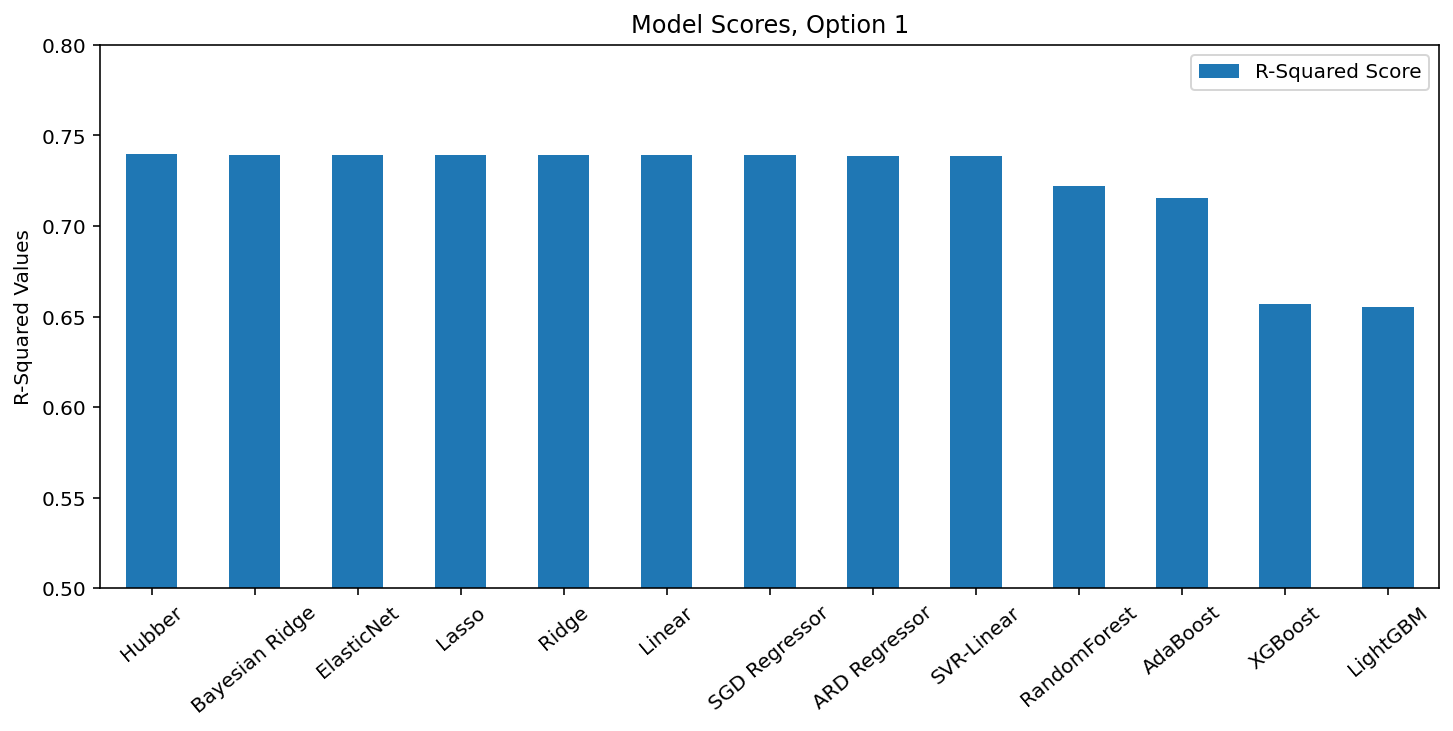

In [34]:
option = 1

df_results_option_1 = model_training(X1_train_scaled,y1_train,option)

df_results_option_1

In [35]:
# Pick a model and perform hyper-parameter tuning

model_select = HuberRegressor()

params = {'epsilon' : [1.0,1.1,1.2,1.3,1.35],
          'alpha'   : [1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'fit_intercept' : [False,True],
          'max_iter' : [100,200,300,400,500]
         }

model_best = opt_best_model(model_select,params,X1_train_scaled,y1_train)

print()
print()

model_coeffs = model_best_predict(model_best,X1_train_scaled,X1_test_scaled,y1_train,y1_test)


{'alpha': 0.1,
 'epsilon': 1.35,
 'fit_intercept': True,
 'max_iter': 400,
 'tol': 1e-05,
 'warm_start': False}
HuberRegressor(alpha=0.1, epsilon=1.35, fit_intercept=True, max_iter=400,
               tol=1e-05, warm_start=False)


R2-Score   : 0.750135
RMSE-Train : $160,035,862.90
RMSE-Test  : $100,371,111.89


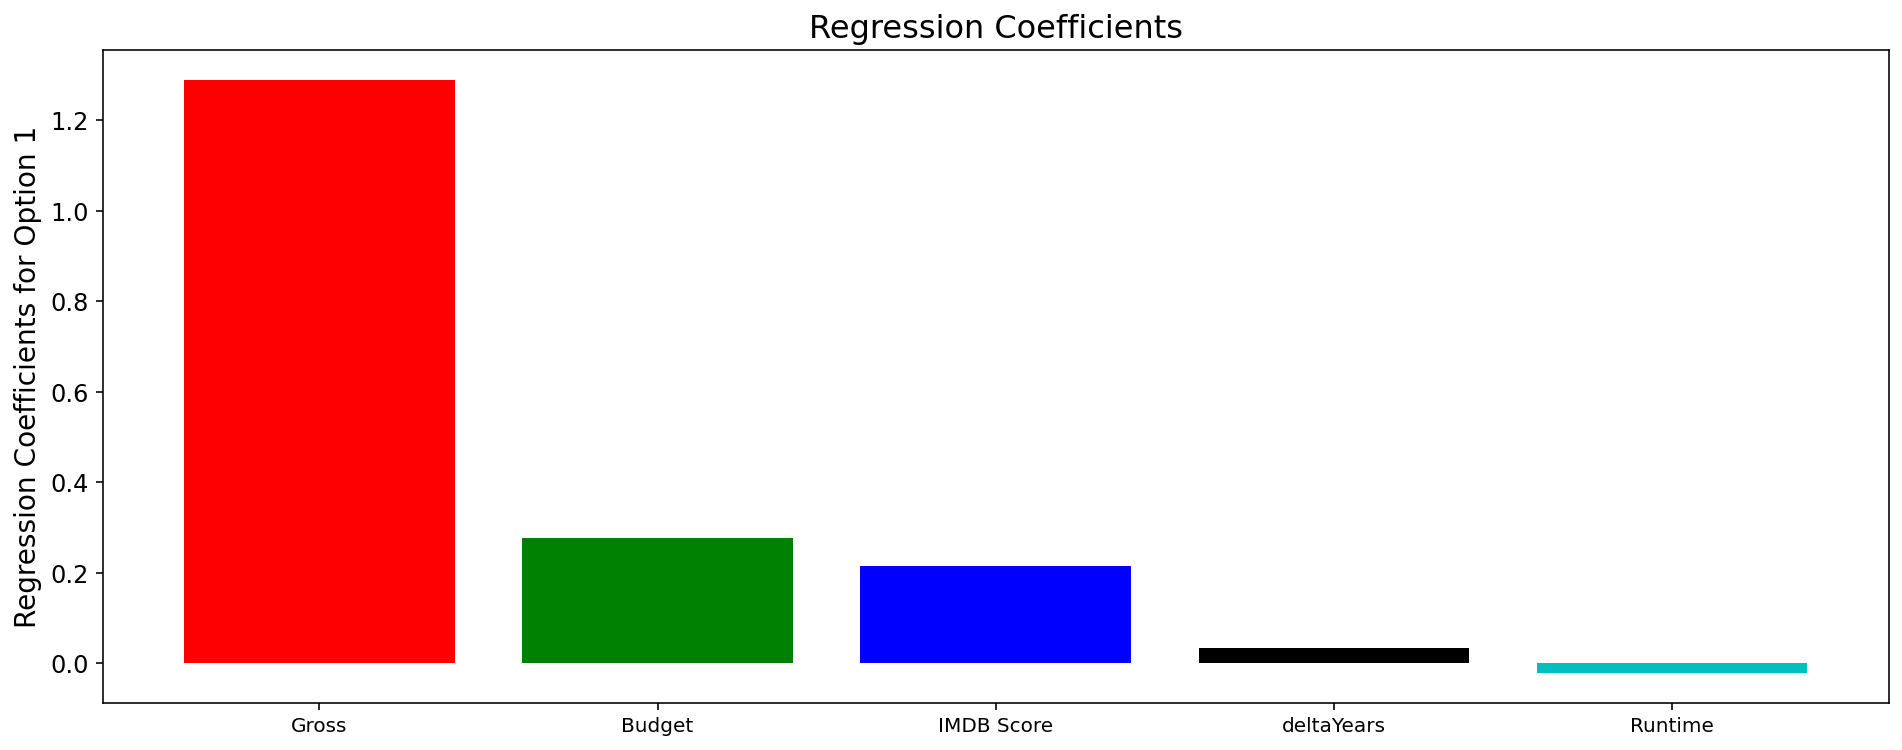

In [36]:
plot_coefficients(X1_train_scaled,model_coeffs,1)

In [37]:
# Get a picture of the skedasticity

def plot_residuals(model,X_test,y_test,zoom,option):
    
    y_pred_test = np.exp(model_best.predict(X_test))

    pct_residuals = (y_pred_test - np.exp(y_test))/np.exp(y_test)*100

    plt.figure(figsize=(14,6))
    plt.scatter(y_pred_test/1e6,pct_residuals,color='red');
    
    plt.xlabel('Predicted Box Office Sequel (USD), Millions',fontsize=14);
    plt.ylabel('Percent Residual (%)',fontsize=14);
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.xticks(np.arange(0, 1000+1, 100))
    
    if zoom == 'Y':
        plt.axis([-10, 1000, -250, 1000])
    
    plt.axhline(y = 0, color='black');
    
    plt.grid()
    
    if zoom == 'Y':
        plt.savefig('./images/residuals_option_{}_zoom.svg'.format(option))
        plt.savefig('./images/residuals_option_{}_zoom.png'.format(option))
        plt.title('Residual vs Predicted Box Office Returns, Option {}, Zoom'.format(option),fontsize=16);
    else:
        plt.savefig('./images/residuals_option_{}.svg'.format(option))
        plt.savefig('./images/residuals_option_{}.png'.format(option))
        plt.title('Residual vs Predicted Box Office Returns, Option {}'.format(option),fontsize=16);

#pct_residuals

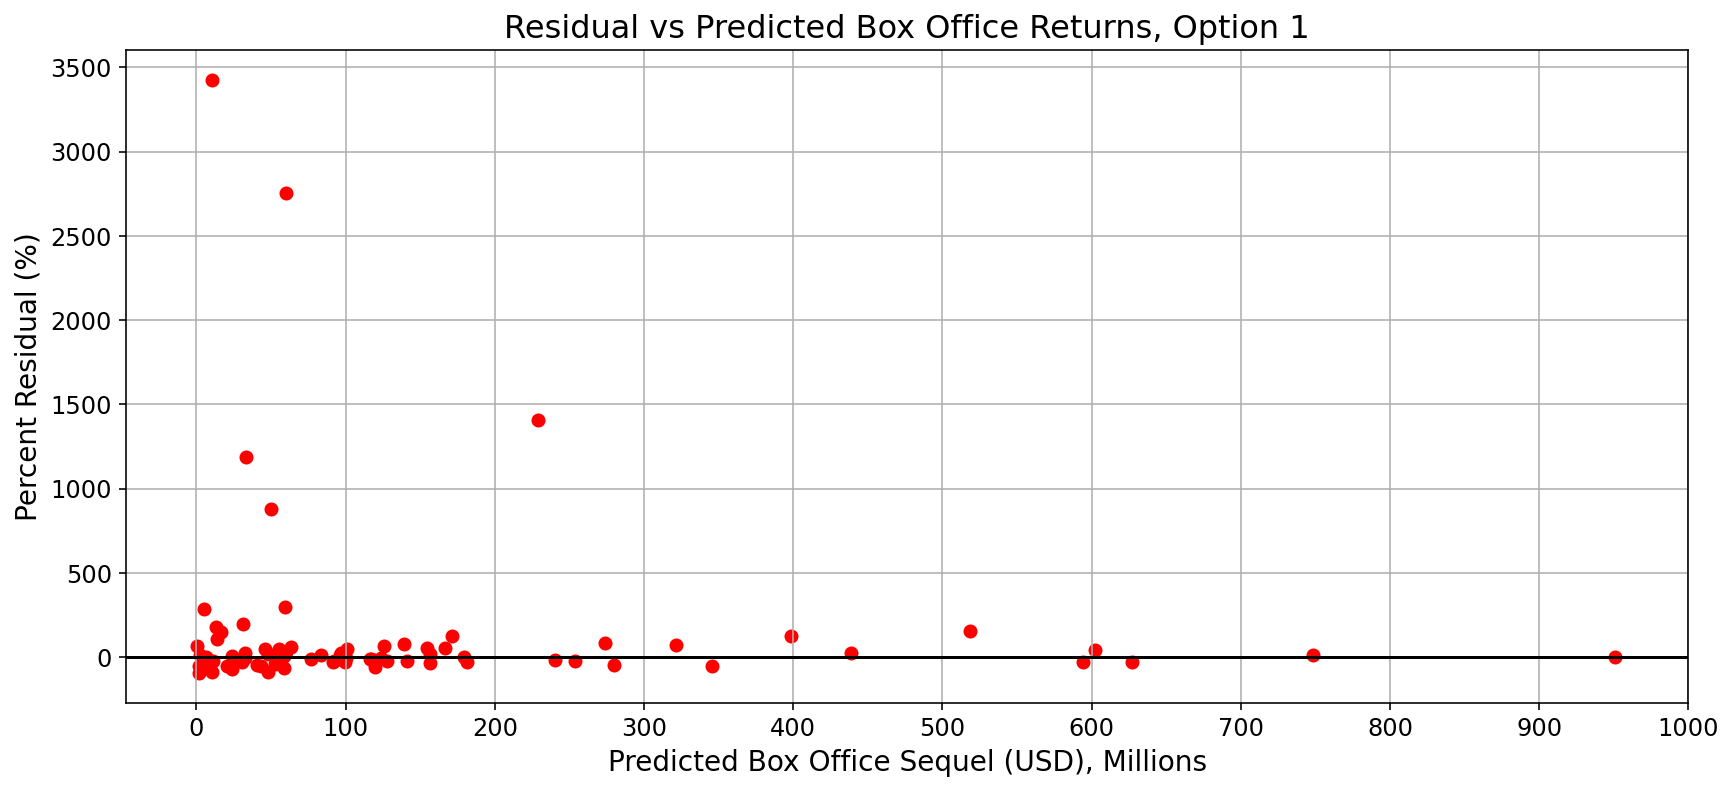

In [38]:
option = 1
zoom = 'N'

plot_residuals(model_best,X1_test_scaled,y1_test,zoom,1)

There are still a number of outliers here that the model cannot predict really well. Notice the discrepancy of over 1,000%. These could most likely be sequels that severely over-performed or under-performed compared to its original. Notice that the original movie perhaps did not make very much at the time and suddenly because of say it becoming a cult-classic, its sequel becomes extremely popular.

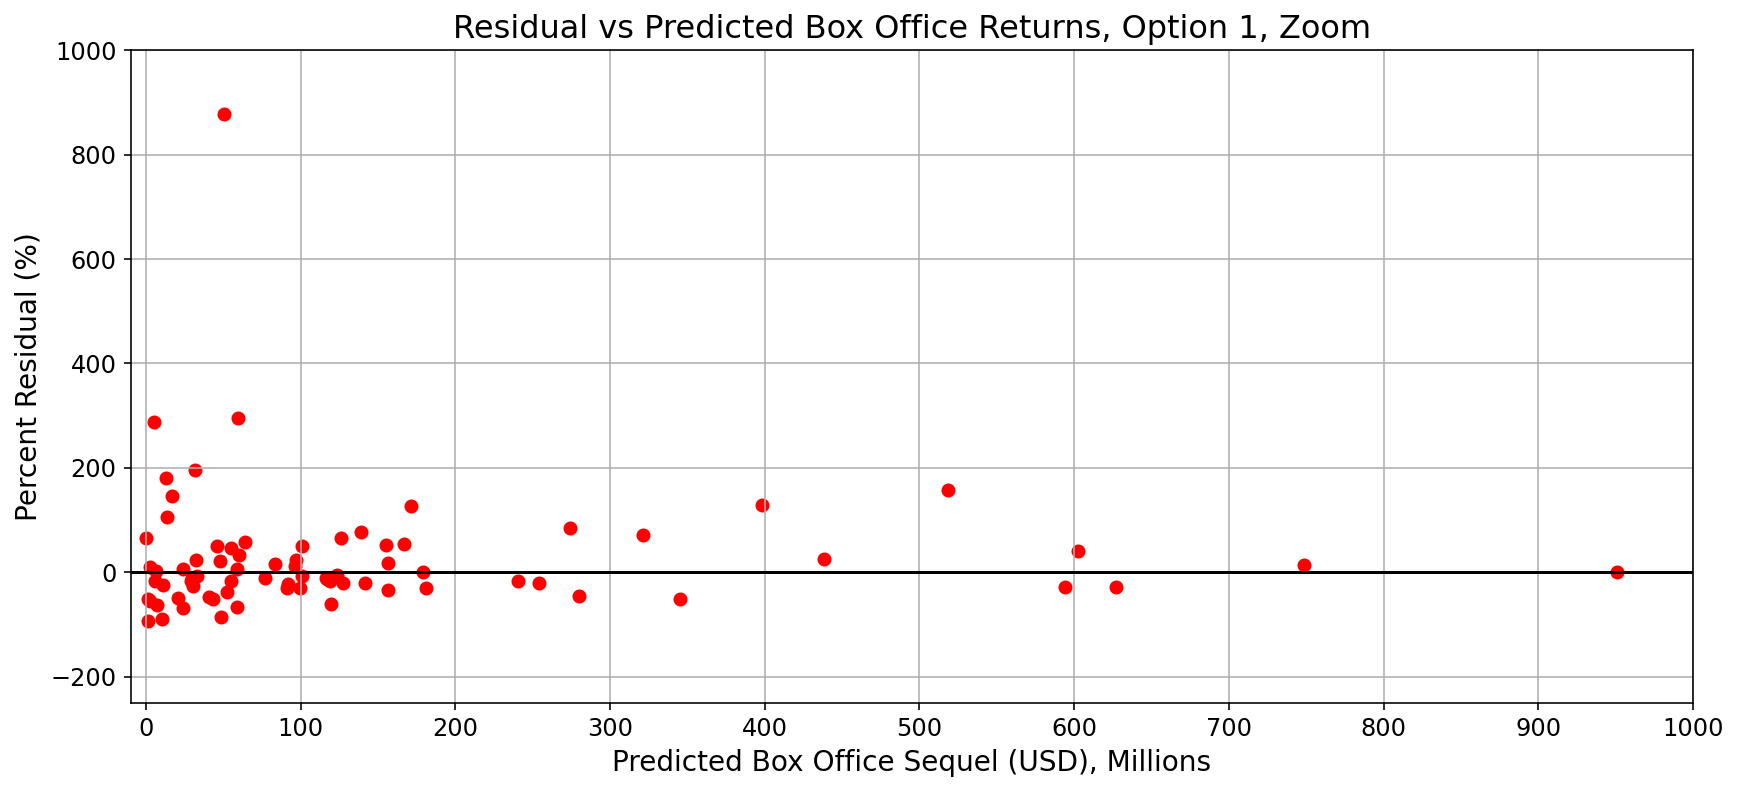

In [39]:
option = 1
zoom = 'Y'

plot_residuals(model_best,X1_test_scaled,y1_test,zoom,1)

Based on our EDA, it is no surprise that the returns of the original strongly dictates the direction of its sequel. It is then followed by its budget and IMDB score. The period between release has a slight effect. The runtime however, has a slight negative effect. In this case, perhaps do not have a too long of a movie.

To check this further, one has to find out which data points is causing the large percent residual error. Look at the one that is close to 1,000% error and check which movie it is. Those could potentially be outliers that is adversely affecting the model.

### Modeling - Option 2

2. Number 1 with rel_YearOrg, rel_MonthOrg,...

In [40]:
X2 = pd.concat([X1, df_rel_time], axis=1)

X2 = X2.reset_index(drop=True) 
X2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   IMDB Score    533 non-null    float64
 1   Runtime       533 non-null    int64  
 2   deltaYears    533 non-null    float64
 3   LogBudget     533 non-null    float64
 4   LogGross      533 non-null    float64
 5   rel_YearOrg   533 non-null    int64  
 6   rel_MonthOrg  533 non-null    int64  
 7   rel_DOWOrg    533 non-null    int64  
 8   rel_DayOrg    533 non-null    int64  
dtypes: float64(4), int64(5)
memory usage: 37.6 KB


In [41]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.15, random_state=2020)

# Standardize training data
sc2 = StandardScaler()

X2_train_scaled = pd.DataFrame(sc2.fit_transform(X2_train), columns=X2_train.columns)
X2_test_scaled  = pd.DataFrame(sc2.transform(X2_test), columns=X2_test.columns)

,R-Squared Score
Hubber,0.744471
Bayesian Ridge,0.743228
Lasso,0.743151
ElasticNet,0.743122
SGD Regressor,0.743117
Ridge,0.743063
Linear,0.743063
ARD Regressor,0.742947
SVR-Linear,0.742613
RandomForest,0.723940


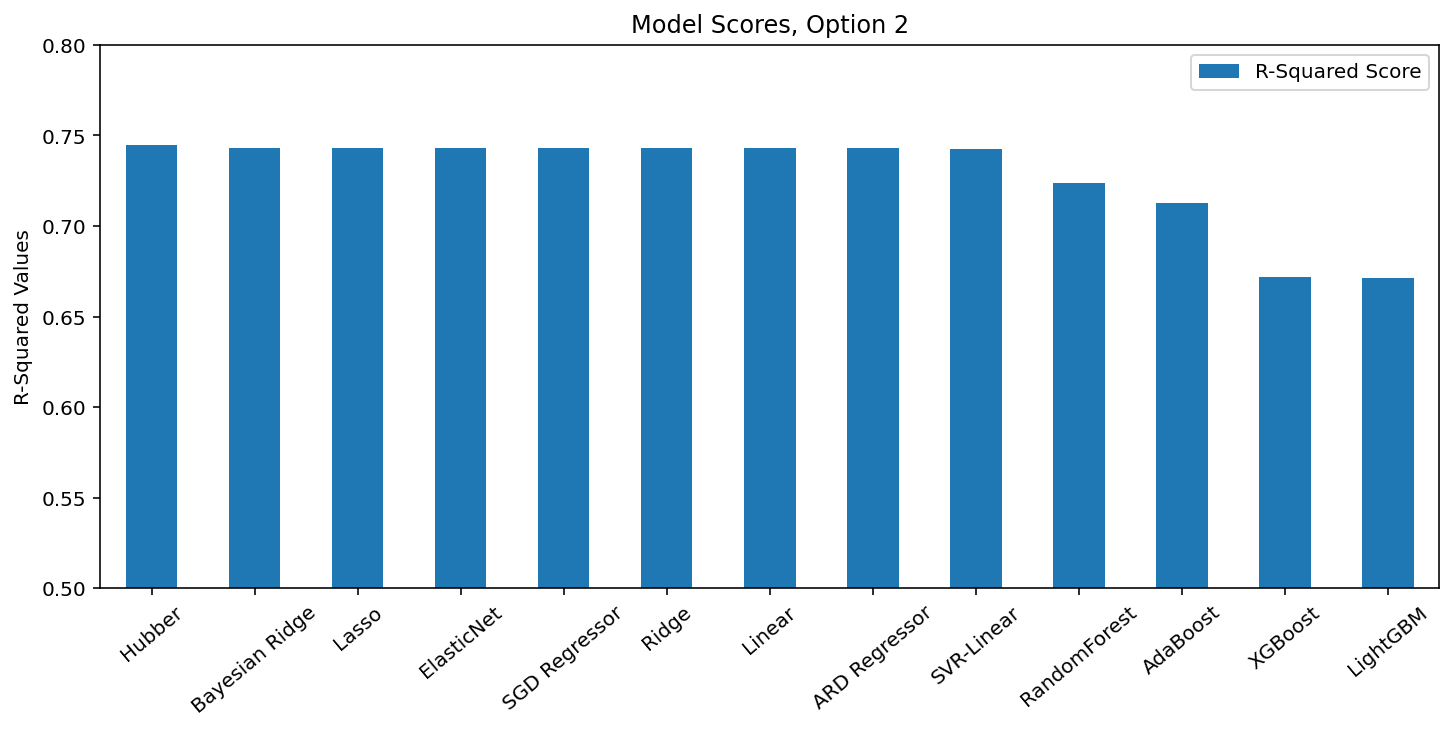

In [42]:
df_results_option_2 = model_training(X2_train_scaled,y2_train,2)

df_results_option_2

In [43]:
model_select = HuberRegressor()

params = {'epsilon' : [1.0,1.1,1.2,1.3,1.35],
          'alpha'   : [1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'fit_intercept' : [False,True],
          'max_iter' : [100,200,300,400,500]
         }
    
model_best = opt_best_model(model_select,params,X2_train_scaled,y2_train)

print()
print()

model_coeffs = model_best_predict(model_best,X2_train_scaled,X2_test_scaled,y2_train,y2_test)
    

{'alpha': 0,
 'epsilon': 1.35,
 'fit_intercept': True,
 'max_iter': 500,
 'tol': 1e-05,
 'warm_start': False}
HuberRegressor(alpha=0, epsilon=1.35, fit_intercept=True, max_iter=500,
               tol=1e-05, warm_start=False)


R2-Score   : 0.757445
RMSE-Train : $159,511,440.74
RMSE-Test  : $101,648,516.79


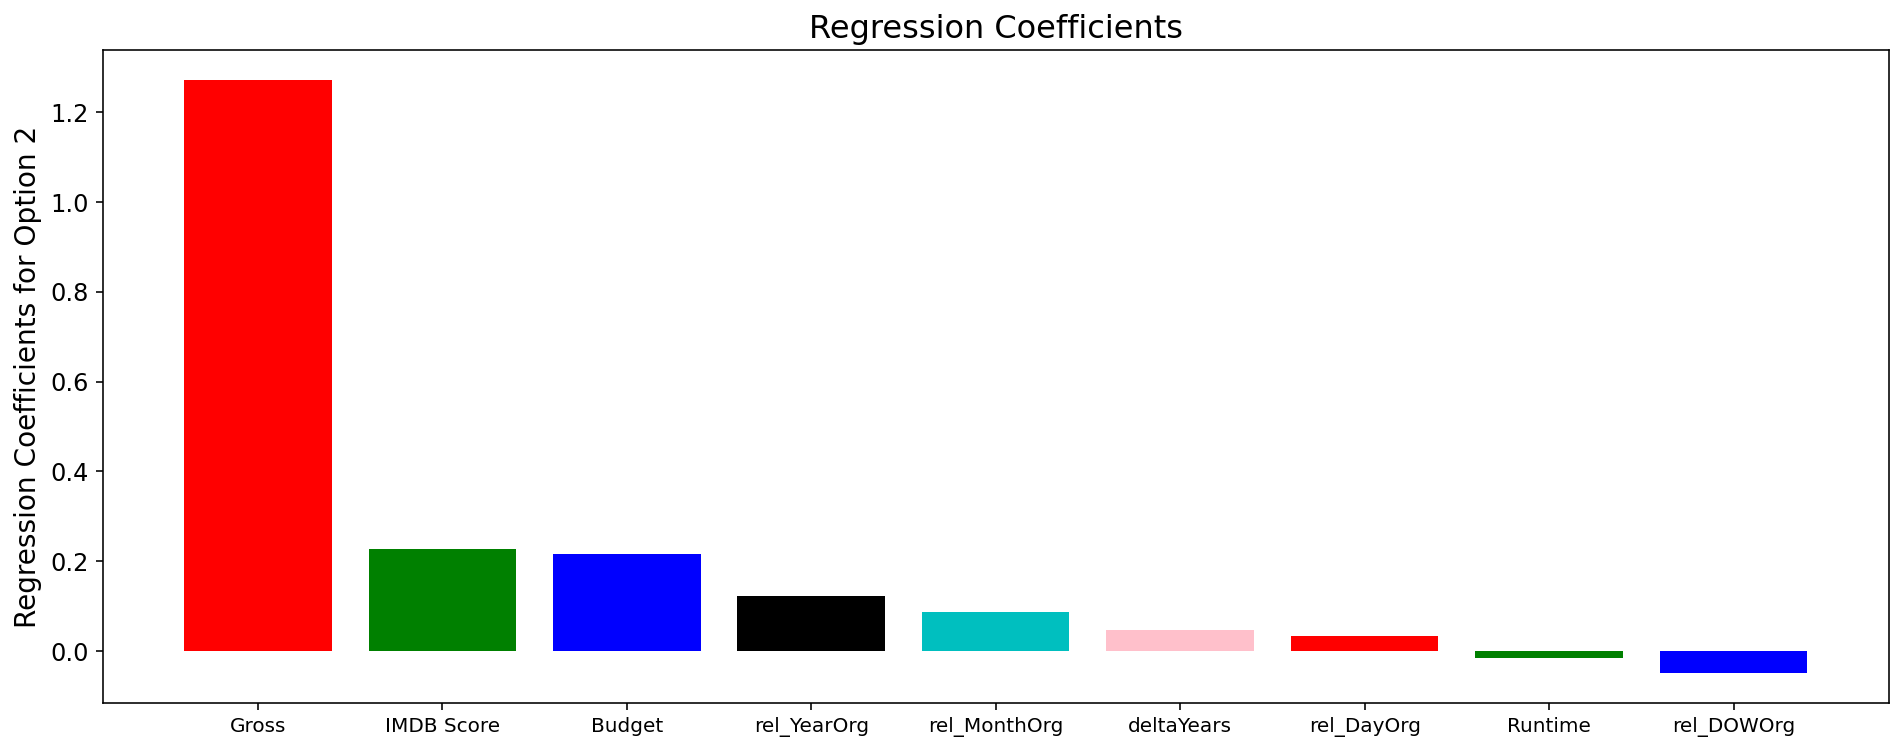

In [44]:
plot_coefficients(X2_train_scaled,model_coeffs,2)

### Modeling - Option 3

3. Number 2 with Ratings

In [45]:
X3 = pd.concat([X2, df_rating], axis=1)

X3.head()

,IMDB Score,Runtime,deltaYears,LogBudget,LogGross,rel_YearOrg,rel_MonthOrg,rel_DOWOrg,rel_DayOrg,r_G,r_PG,r_PG-13,r_R
0,7.3,121,2.160209,18.749984,20.530924,2002,5,4,3,0,0,1,0
1,8.7,136,4.123288,17.958645,19.958287,1999,3,2,31,0,0,0,1
2,8.8,178,0.996598,18.348110,20.604294,2001,12,2,19,0,0,1,0
3,8.9,201,8.994025,18.358805,20.856239,2003,12,2,17,0,0,1,0
4,7.8,161,1.010288,19.231611,20.680741,2013,12,4,13,0,0,1,0


In [46]:
# Check indices again
X3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   IMDB Score    533 non-null    float64
 1   Runtime       533 non-null    int64  
 2   deltaYears    533 non-null    float64
 3   LogBudget     533 non-null    float64
 4   LogGross      533 non-null    float64
 5   rel_YearOrg   533 non-null    int64  
 6   rel_MonthOrg  533 non-null    int64  
 7   rel_DOWOrg    533 non-null    int64  
 8   rel_DayOrg    533 non-null    int64  
 9   r_G           533 non-null    uint8  
 10  r_PG          533 non-null    uint8  
 11  r_PG-13       533 non-null    uint8  
 12  r_R           533 non-null    uint8  
dtypes: float64(4), int64(5), uint8(4)
memory usage: 39.7 KB


In [47]:
# Do the usual train test split
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.15, random_state=2020)

#X3_train.head()

In [48]:
def split_and_merge_again(X_train,X_test,y_train,y_test):

    # Now for some crazy gymnastics
    # Doing this since I want to preserve the shuffling order of the target variables
    X_train_num = X_train[['IMDB Score','Runtime','deltaYears','LogBudget',
                         'LogGross','rel_YearOrg','rel_MonthOrg','rel_DOWOrg','rel_DayOrg']]

    X_test_num = X_test[['IMDB Score','Runtime','deltaYears','LogBudget',
                        'LogGross','rel_YearOrg','rel_MonthOrg','rel_DOWOrg','rel_DayOrg']]

    # Extract categorical
    X_train_cat = X_train[['r_G','r_PG','r_PG-13','r_R']]
    X_test_cat  = X_test[['r_G','r_PG','r_PG-13','r_R']]

    # Now reset indexes
    X_train_num = X_train_num.reset_index(drop=True)
    X_train_cat = X_train_cat.reset_index(drop=True)

    X_test_num = X_test_num.reset_index(drop=True)
    X_test_cat = X_test_cat.reset_index(drop=True)

    y_train = y_train.reset_index(drop=True)
    y_test  = y_test.reset_index(drop=True)


    # Standardize training and test data
    scx = StandardScaler()

    X_train_num_scaled = pd.DataFrame(scx.fit_transform(X_train_num),columns=X_train_num.columns)
    X_test_num_scaled  = pd.DataFrame(scx.transform(X_test_num), columns=X_test_num.columns)

    # Concatenate with numerical and categorical data
    X_train_scaled = pd.concat([X_train_num_scaled, X_train_cat], axis=1)
    X_test_scaled = pd.concat([X_test_num_scaled, X_test_cat], axis=1)
    
    return (X_train_scaled,X_test_scaled,y_train,y_test)


In this case, I have not used the split and merge again function to leave the OHE dataframe untouched. So I am then going to standardize the OHE features. The reason I did this was because looking at the coefficients (feature importance) showed the OHE variables were about 14 times higher compared to the numerical variables and it itself did not change the R2 score. Performing a standardization on the OHE variables then minimized them.

I am not sure if this is the correct way or not and will have to check.

In [49]:
standardize_OHE = 'Y'

if standardize_OHE == 'Y':
    sc3 = StandardScaler()
    
    X3_train_scaled = pd.DataFrame(sc3.fit_transform(X3_train),columns=X3_train.columns)
    X3_test_scaled  = pd.DataFrame(sc3.transform(X3_test), columns=X3_test.columns)
    
else:
    
    X3_train_scaled,X3_test_scaled,y3_train,y3_test = split_and_merge_again(X3_train,X3_test,y3_train,y3_test)
        

,R-Squared Score
Hubber,0.742713
Linear,0.742507
Bayesian Ridge,0.742356
Lasso,0.742177
ElasticNet,0.742158
Ridge,0.742098
SVR-Linear,0.741676
SGD Regressor,0.741238
ARD Regressor,0.740819
RandomForest,0.723973


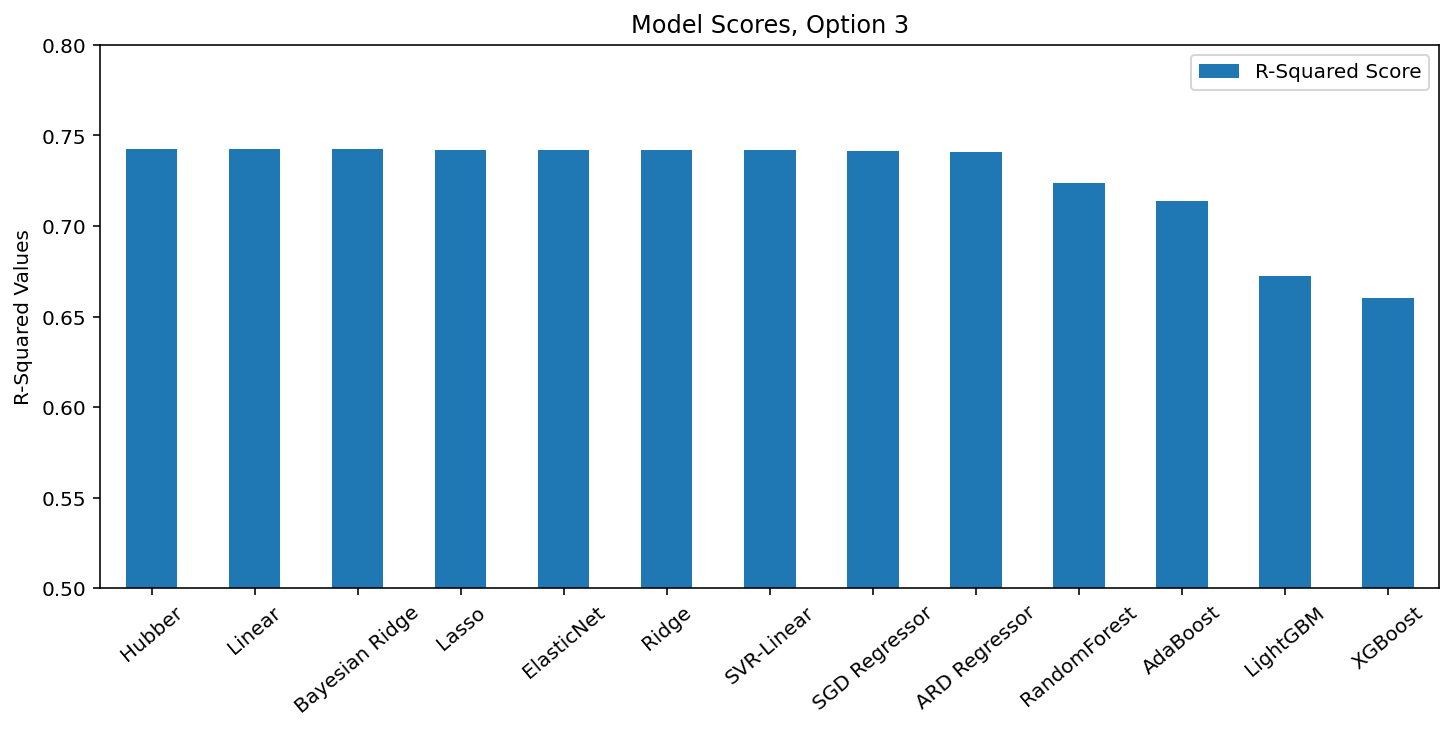

In [50]:
df_results_option_3 = model_training(X3_train_scaled,y3_train,3)

df_results_option_3

In [51]:
model_select = HuberRegressor()

params = {'epsilon' : [1.0,1.1,1.2,1.3,1.35],
          'alpha'   : [1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'fit_intercept' : [False,True],
          'max_iter' : [100,200,300,400,500]
         }

model_best = opt_best_model(model_select,params,X3_train_scaled,y3_train)

{'alpha': 0.3,
 'epsilon': 1.2,
 'fit_intercept': True,
 'max_iter': 400,
 'tol': 1e-05,
 'warm_start': False}
HuberRegressor(alpha=0.3, epsilon=1.2, fit_intercept=True, max_iter=400,
               tol=1e-05, warm_start=False)


In [52]:
model_coeffs = model_best_predict(model_best,X3_train_scaled,X3_test_scaled,y3_train,y3_test)

R2-Score   : 0.758308
RMSE-Train : $158,644,262.16
RMSE-Test  : $102,152,141.08


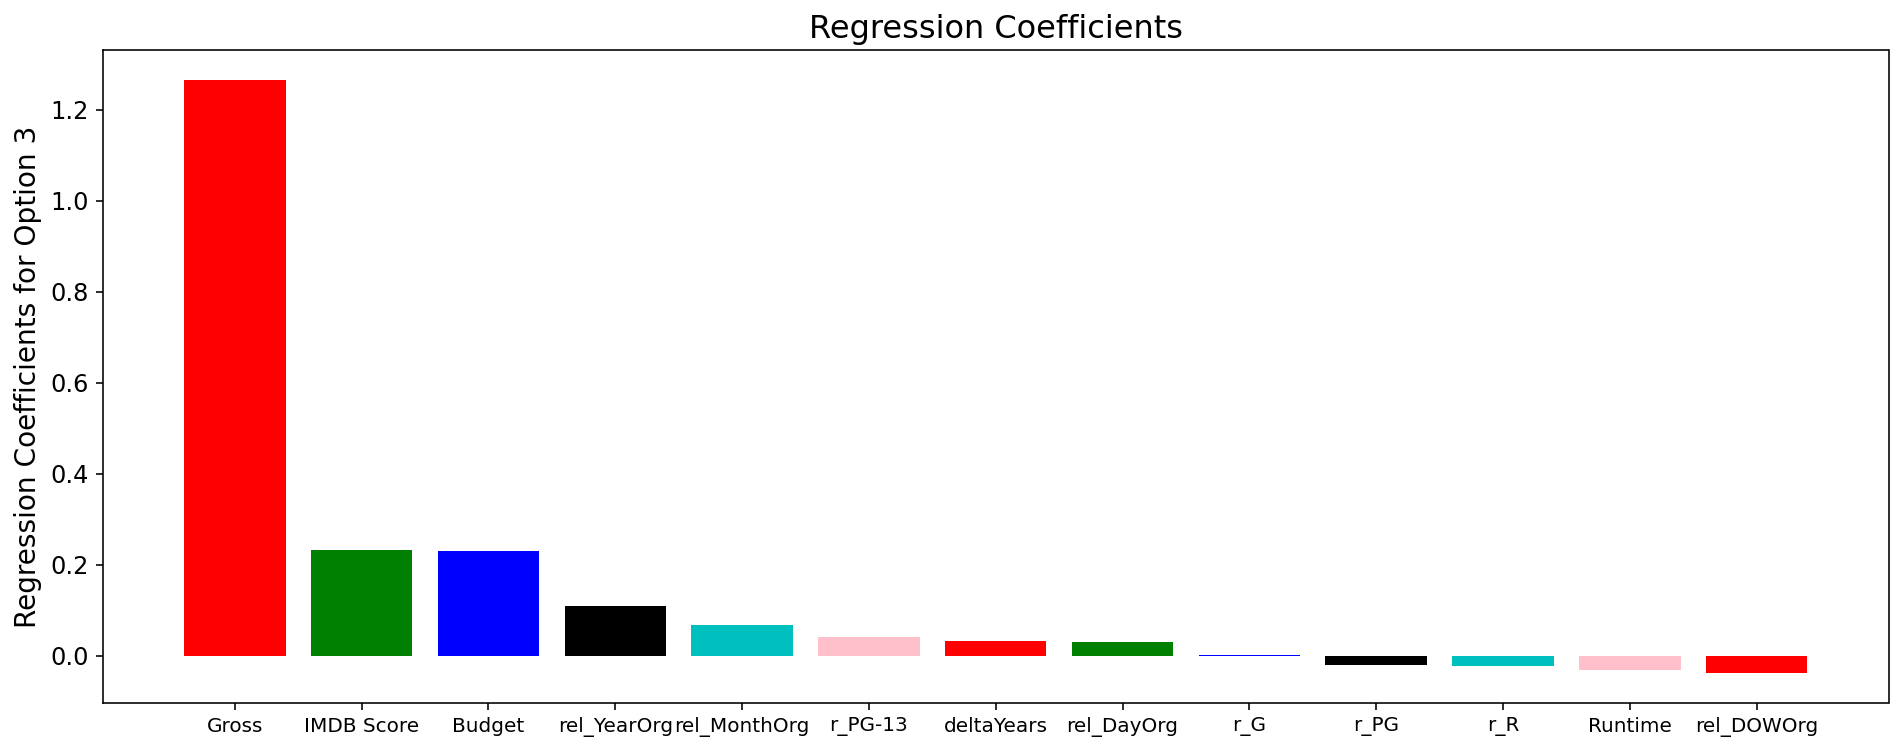

In [53]:
option = 3

plot_coefficients(X3_train,model_coeffs,option)

### Modeling - Option 4

4. Number 3 with Genres

In [54]:
X4 = pd.concat([X3, df_genres], axis=1)

X4.head()

,IMDB Score,Runtime,deltaYears,LogBudget,LogGross,rel_YearOrg,rel_MonthOrg,rel_DOWOrg,rel_DayOrg,r_G,...,g_Horror,g_Music,g_Musical,g_Mystery,g_Romance,g_Sci-Fi,g_Sport,g_Thriller,g_War,g_Western
0,7.3,121,2.160209,18.749984,20.530924,2002,5,4,3,0,...,0,0,0,0,0,1,0,0,0,0
1,8.7,136,4.123288,17.958645,19.958287,1999,3,2,31,0,...,0,0,0,0,0,1,0,0,0,0
2,8.8,178,0.996598,18.348110,20.604294,2001,12,2,19,0,...,0,0,0,0,0,0,0,0,0,0
3,8.9,201,8.994025,18.358805,20.856239,2003,12,2,17,0,...,0,0,0,0,0,0,0,0,0,0
4,7.8,161,1.010288,19.231611,20.680741,2013,12,4,13,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y, test_size=0.15, random_state=2020)

sc4 = StandardScaler()

X4_train_scaled = pd.DataFrame(sc4.fit_transform(X4_train),columns=X4_train.columns)
X4_test_scaled  = pd.DataFrame(sc4.transform(X4_test), columns=X4_test.columns)



,R-Squared Score
Bayesian Ridge,7.422476e-01
Lasso,7.413375e-01
ElasticNet,7.411921e-01
Ridge,7.409474e-01
SVR-Linear,7.397071e-01
ARD Regressor,7.392677e-01
RandomForest,7.228246e-01
AdaBoost,7.117578e-01
LightGBM,6.917784e-01
XGBoost,6.793984e-01


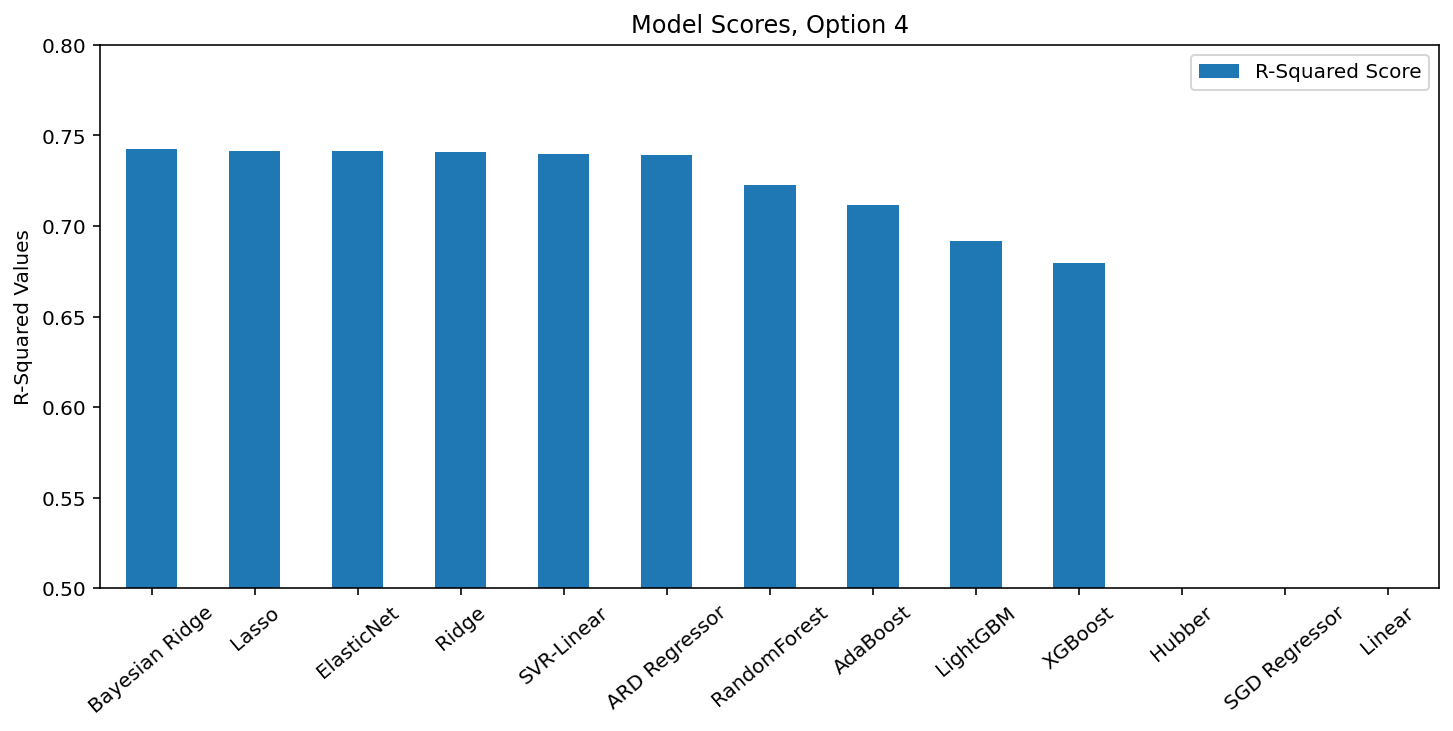

In [56]:
option = 4

df_results_option_4 = model_training(X4_train_scaled,y4_train,option)

df_results_option_4

Here there are too many categorical features for the Genre itself and is thus causing some of the Regressors to perform really poorly. One way to fix this is to decrease the number of unique genres and pick the top 10 or so.

# Comments & Remarks

After going through several rounds or options of modeling, the highest R2 score achieved is 0.75. This is not bad considering that the design matrix, `[X]*b = y`, has almost no prior knowledge regarding details of its sequel. The exception here is that the design matrix has information about when the release date of the sequel is going to be. A potentially more accurate way will be to include the allocated budget for its sequel, i.e. the sequel has been green lit based on the success of its original. 